In [2]:
import numpy as np
import pandas as pd
from sklearn.base import clone 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt
import time
import json
import sys
import os
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.utils import CrossValidation
from src.feature_selection import CustomRFECV
from src.feature_selection import IntrinsicFeatureSelection as ifs
from src.plotting import plot_pairwise_correlations

# Load in the data

In [3]:
proc = GatherFeatureDatasets(is_p=True)

In [4]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')

In [5]:
# Use station YUF for experimenting with models because it has 1433 training examples, 
# which is ~half as much as YNR, so training should go faster. But should still be enough 
# examples for training good models. It is also one of the stations with a 
# UUSS correction, so already used for magnitude calculations and amplitudes should be good quality. 
stat = "YUF"
station_feature_dict_rel, station_meta_dict_rel, feature_names_rel = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='dist')

YUF
X shape: (1676, 45), y shape: (1676,)


In [7]:
station_feature_dict_abs, station_meta_dict_abs, feature_names_abs = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='coord')

YUF
X shape: (1676, 45), y shape: (1676,)


In [8]:
feature_names_rel

array(['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7', 'amp_ratio_8',
       'amp_ratio_9', 'amp_ratio_10', 'amp_ratio_11', 'amp_ratio_12',
       'amp_ratio_13', 'amp_ratio_14', 'amp_ratio_15', 'amp_ratio_16',
       'amp_ratio_17', 'amp_ratio_18', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11',
       'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17',
       'amp_18', 'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km',
       'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

In [9]:
feature_names_abs

array(['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7', 'amp_ratio_8',
       'amp_ratio_9', 'amp_ratio_10', 'amp_ratio_11', 'amp_ratio_12',
       'amp_ratio_13', 'amp_ratio_14', 'amp_ratio_15', 'amp_ratio_16',
       'amp_ratio_17', 'amp_ratio_18', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11',
       'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17',
       'amp_18', 'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km', 'source_latitude',
       'source_longitude'], dtype='<U25')

In [10]:
X_rel = station_feature_dict_rel['X_train']
y_rel = station_meta_dict_rel['y_train']

In [11]:
X_abs = station_feature_dict_abs['X_train']
y_abs = station_meta_dict_abs['y_train']

# Use RFECV to select N with different estimator models

In [12]:
### Set Parameters ###
cv_random_state=2652124
# The model to used to estimate feature importance 
# estimator_model =  DecisionTreeRegressor()
# # Boolean - True if data for estimator_model needs to be scaled
# estimator_scaler = False
# The main model to fit
predictor_model = SVR(kernel='rbf')
# Boolean - True if data for model needs to be scaled 
model_scaler = True
# The scoring method to use in RFECV and GridCV
scoring_method = 'r2'
# The function used to evaluate the performance on the test model
score_func = r2_score
# True if a larger score_func value is better
larger_score_is_better = True
# The parameter space for GridCV to search
# Decrease upper-limit of C for linear model because 100 is very slow 
svr_Cspace = [1, 10, 100]
svr_gspace = [0.1, 0.01, 0.001]
param_grid = [
    {'m__C': svr_Cspace, 'm__gamma': svr_gspace},
]
# The number of jobs for RFECV and GridCV to use
n_jobs = 10
# number of folds for outer CV
cv_folds_outer = 10
# number of times to repeat outer CV
n_outer_repeats = 1
# number of folds for inner CV (used for hyperparameter tuning)
cv_folds_inner = 5
# number of folds for the final hyperparameter grid search
cv_folds_hp = 10
# Run grid search over all features
run_gridsearchcv_all = True

### Intrisic feature selection information 
# Function that takes in X, y, list of np arrays containing 
# the indices of features to filter, and K features to select
if_feat_inds = [np.arange(0, 18), np.arange(18, 36)]
if_K = 5
#####################

In [13]:
estimator_models = [DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), SVR(kernel='linear')]
estimator_scalers = [False, False, False, True]

In [14]:
estimator_rfe_results_abs = {}
for i in range(len(estimator_models)):
  estimator_model = estimator_models[i]
  estimator_scaler = estimator_scalers[i]
  mname = type(estimator_model).__name__
  print(mname, 'Estimator Scaler:', estimator_scaler)
  feat_selection_results = CustomRFECV.do_rfecv(X_abs,
                                                y_abs,
                                              estimator_model,
                                              predictor_model,
                                              param_grid,
                                              estimator_scaler=estimator_scaler,
                                              predictor_scaler=model_scaler,
                                              score_func=score_func,
                                              scoring_method=scoring_method,
                                              n_jobs=n_jobs,
                                              cv_folds_outer=cv_folds_outer,
                                              cv_folds_inner=cv_folds_inner,
                                              n_outer_repeats=n_outer_repeats,
                                              cv_random_state=cv_random_state,
                                              larger_score_is_better=larger_score_is_better,
                                              intrinsic_filter_func=ifs.MI_filter_func,
                                              feature_inds_to_filter=if_feat_inds,
                                              intrinsic_filter_K=if_K
                                              )
  estimator_rfe_results_abs[mname] = feat_selection_results

DecisionTreeRegressor Estimator Scaler: False
reducing features to 19
Fold 0: N=9, test_score=0.897
reducing features to 19
Fold 1: N=10, test_score=0.896
reducing features to 19
Fold 2: N=7, test_score=0.907
reducing features to 19
Fold 3: N=7, test_score=0.903
reducing features to 19
Fold 4: N=6, test_score=0.920
reducing features to 19
Fold 5: N=13, test_score=0.912
reducing features to 19
Fold 6: N=8, test_score=0.904
reducing features to 19
Fold 7: N=12, test_score=0.924
reducing features to 19
Fold 8: N=12, test_score=0.907
reducing features to 19
Fold 9: N=15, test_score=0.898
total time: 611.53 s
Selected number of features: 16 (avg. score of 0.90)
RandomForestRegressor Estimator Scaler: False
reducing features to 19
Fold 0: N=7, test_score=0.924
reducing features to 19
Fold 1: N=16, test_score=0.892
reducing features to 19
Fold 2: N=7, test_score=0.902
reducing features to 19
Fold 3: N=8, test_score=0.907
reducing features to 19
Fold 4: N=6, test_score=0.920
reducing features 

In [15]:
import json
from src.utils import NumpyEncoder
outpath = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_selection/experiment_YUF'
outfile = 'rfecv.absDist.estimators.json'
with open(os.path.join(outpath, outfile), 'w') as fp:
    json.dump(estimator_rfe_results_abs, fp, indent=4, cls=NumpyEncoder)

In [17]:
def select_N_one_standard_error(N_avgs):
    max_val = np.max(N_avgs)
    ste = np.std(N_avgs)/np.sqrt(len(N_avgs))
    selected_N_ind = np.min(np.where((max_val - N_avgs) < ste))
    return selected_N_ind+1

In [19]:
for key in estimator_rfe_results_abs.keys():
    N_avgs = np.average(estimator_rfe_results_abs[key]['N_scores'], axis=0)
    estimator_rfe_results_abs[key]['oste_N'] = select_N_one_standard_error(N_avgs)

Text(0.02, 0.5, '$R^2$')

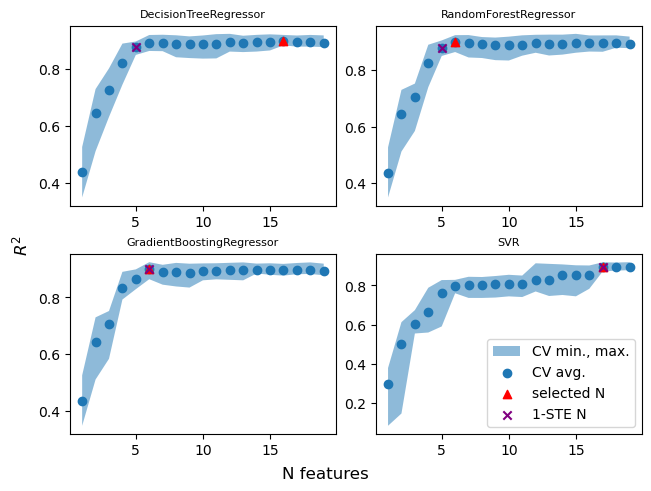

In [24]:
fig, axes = plt.subplots(2, 2, constrained_layout=True)
axes = axes.flatten()
for i, key in enumerate(estimator_rfe_results_abs.keys()):
    model_results = estimator_rfe_results_abs[key]
    full_score_array = model_results['N_scores']
    N_avgs = np.average(full_score_array, axis=0)
    N_min = np.min(full_score_array, axis=0)
    N_max = np.max(full_score_array, axis=0)
    N_feats_to_use = model_results['best_N']
    oste_N = model_results['oste_N']
    x = np.arange(N_avgs.shape[0])+1
    axes[i].fill_between(x, N_min, N_max, alpha=0.5, label='CV min., max.')
    axes[i].scatter(x, N_avgs, color='C0', label='CV avg.')
    axes[i].scatter(N_feats_to_use, N_avgs[N_feats_to_use-1], marker="^", color='r', label='selected N')
    axes[i].scatter(oste_N, N_avgs[oste_N-1], marker="x", color='purple', label='1-STE N')    
    axes[i].set_title(key, fontsize=8)
    #axes[i].grid()

axes[i].legend(loc='lower right')

fig.supxlabel("N features")
fig.supylabel("$R^2$")

## Use the selected N values (OSTE and Best) on the entire training set

In [72]:
# Filter the entire training dataset using MI and the same parameters used in CV
mi_selected_features, mi_filtered_feature_inds = ifs.MI_filter_func(X_abs, 
                                                                    y_abs, 
                                                                    if_feat_inds, 
                                                                    if_K)
print(feature_names_abs[mi_selected_features[0]], feature_names_abs[mi_selected_features[1]])
X_mi = X_abs[:, mi_filtered_feature_inds]
print(X_mi.shape)

['amp_ratio_7' 'amp_ratio_6' 'amp_ratio_4' 'amp_ratio_5' 'amp_ratio_2'] ['amp_1' 'amp_2' 'amp_4' 'amp_3' 'amp_7']
(1676, 19)


In [73]:
feature_names_abs[mi_filtered_feature_inds]

array(['amp_ratio_2', 'amp_ratio_4', 'amp_ratio_5', 'amp_ratio_6',
       'amp_ratio_7', 'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_7',
       'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km', 'source_latitude',
       'source_longitude'], dtype='<U25')

In [74]:
np.unique([estimator_rfe_results_abs[key]['best_N'], estimator_rfe_results_abs[key]['oste_N']])

array([17])

In [75]:
# Set up SVR hyperparameter grid search
# If this isn't reran when the feature selection is reran then
# the results may be slightly different
hp_grid_search, hp_cv = CrossValidation.setup_cv(predictor_model, 
                                                param_grid, 
                                                model_scaler=model_scaler, 
                                                scoring_method=scoring_method, 
                                                n_jobs=n_jobs, 
                                                cv_folds=cv_folds_outer, 
                                                cv_random_state=cv_random_state, 
                                                refit_model=False)
full_estimator_rfe_results_abs = {}
for i in range(len(estimator_models)):
    estimator_model = estimator_models[i]
    estimator_scaler = estimator_scalers[i]
    mname = type(estimator_model).__name__
    print(mname, 'Estimator Scaler:', estimator_scaler)
    estimator_pipeline = CrossValidation.make_simple_pipeline(estimator_model, 
                                                          estimator_scaler)
    N_feats_to_use = np.unique([estimator_rfe_results_abs[mname]['best_N'], 
                                estimator_rfe_results_abs[mname]['oste_N']])
    print(N_feats_to_use)
    N_results = {}
    for N_i in N_feats_to_use:
        fselector, gs_results, _ = CustomRFECV.custom_rfe(X_mi, 
                                                        y_abs,
                                                        estimator_pipeline,
                                                        N_i,
                                                        hp_grid_search)
        cv_mean, cv_std, params = CrossValidation.get_gridsearchcv_best_results(gs_results)
        print(f'{N_i}: CV Mean: {cv_mean:0.2f}, CV STD: {cv_std:0.2f}')
        N_results[str(N_i)] = {'selected_feature_inds':mi_filtered_feature_inds[fselector.support_],
                          'pred_cv_mean':cv_mean,
                          'pred_cv_std':cv_std,
                          'pre_cv_params':params}
    full_estimator_rfe_results_abs[mname] = N_results

DecisionTreeRegressor Estimator Scaler: False
[ 5 16]


5: CV Mean: 0.88, CV STD: 0.02
16: CV Mean: 0.89, CV STD: 0.02
RandomForestRegressor Estimator Scaler: False
[5 6]
5: CV Mean: 0.88, CV STD: 0.02
6: CV Mean: 0.90, CV STD: 0.02
GradientBoostingRegressor Estimator Scaler: False
[6]
6: CV Mean: 0.90, CV STD: 0.02
SVR Estimator Scaler: True
[17]
17: CV Mean: 0.90, CV STD: 0.01


In [76]:
for key in full_estimator_rfe_results_abs.keys():
    results = full_estimator_rfe_results_abs[key]
    N_key = list(results.keys())[0]
    results = results[N_key]
    print(key, N_key, f"{results['pred_cv_mean']:0.2f}", feature_names_abs[results['selected_feature_inds']])


DecisionTreeRegressor 5 0.88 ['amp_1' 'amp_2' 'signal_variance' 'source_latitude' 'source_longitude']
RandomForestRegressor 5 0.88 ['amp_1' 'amp_2' 'amp_7' 'source_latitude' 'source_longitude']
GradientBoostingRegressor 6 0.90 ['amp_1' 'amp_2' 'amp_7' 'source_depth_km' 'source_latitude'
 'source_longitude']
SVR 17 0.90 ['amp_ratio_4' 'amp_ratio_5' 'amp_ratio_6' 'amp_ratio_7' 'amp_1' 'amp_2'
 'amp_3' 'amp_4' 'amp_7' 'signal_dominant_amplitude' 'noise_max_amplitude'
 'signal_max_amplitude' 'signal_variance' 'noise_variance'
 'source_depth_km' 'source_latitude' 'source_longitude']


In [77]:
results = full_estimator_rfe_results_abs['RandomForestRegressor']
N_key = list(results.keys())[1]
results = results[N_key]
print('RFR', N_key, f"{results['pred_cv_mean']:0.2f}", feature_names_abs[results['selected_feature_inds']])


RFR 6 0.90 ['amp_1' 'amp_2' 'amp_7' 'source_depth_km' 'source_latitude'
 'source_longitude']


In [78]:
outfile = 'rfecv.absDist.estimators.fullTrain.json'
with open(os.path.join(outpath, outfile), 'w') as fp:
    json.dump(full_estimator_rfe_results_abs, fp, indent=4, cls=NumpyEncoder)

Text(0.5, 1.0, 'SVR CV Performance with Selected Features (Absolute Distances)')

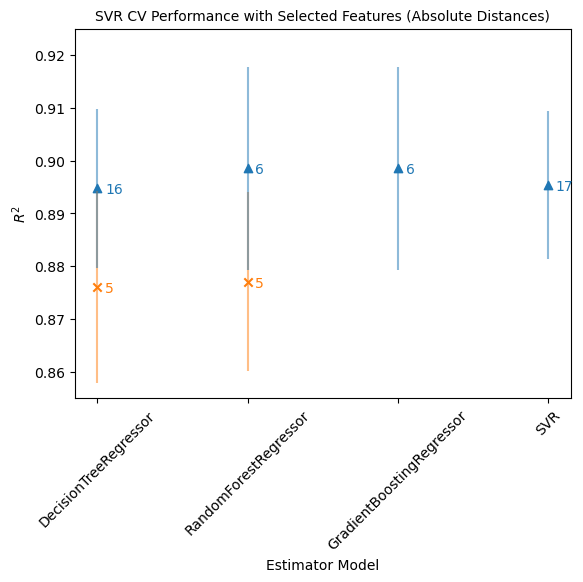

In [79]:
for k_ind, key in enumerate(full_estimator_rfe_results_abs.keys()):
    results = full_estimator_rfe_results_abs[key]
    N_prev = -1
    n_vals = len(results.keys())
    for i, N_i in enumerate(results.keys()):
        N_i_int = int(N_i)
        assert N_i_int > N_prev, "Ns are out of order"
        sym = "^"
        color='C0'
        if n_vals > 1 and i == 0:
            sym = "x"
            color='C1'
        cv_mean = results[N_i]['pred_cv_mean']
        cv_std = results[N_i]['pred_cv_std']
        plt.scatter(k_ind, cv_mean, marker=sym, color=color)
        plt.vlines(k_ind, cv_mean-cv_std, cv_mean+cv_std, color=color, alpha=0.5)
        plt.text(k_ind+0.05, cv_mean-0.001, N_i, color=color)
        N_prev = N_i_int

plt.xticks(np.arange(len(full_estimator_rfe_results_abs.keys())), 
           full_estimator_rfe_results_abs.keys(),
           rotation=45)
plt.xlabel('Estimator Model')
plt.ylabel('$R^2$')
plt.ylim([0.855, 0.925])
plt.title("SVR CV Performance with Selected Features (Absolute Distances)", fontsize=10)

# Use DecisionTree estimator and different predictor models

Select DecisionTree because results pretty similar to GBT but much faster. The features that are not being selected (related to location) will be fixed with human-in-the-loop selection later as feature selection will not be fully automated.

In [95]:
# The model to used to estimate feature importance 
estimator_model =  DecisionTreeRegressor()
# Boolean - True if data for estimator_model needs to be scaled
estimator_scaler = False

predictor_models = {"RF": RandomForestRegressor(random_state=0), 
                    "GBT": GradientBoostingRegressor(random_state=0)}
model_scaler = False

param_grids = {"RF": {"m__max_features": [1, 4, 6],
                      "m__n_estimators": [100, 500, 1000]},
               "GBT": {'m__n_estimators': [100, 500, 1000], 
                       'm__max_depth': [1, 4, 7]}
              }

In [96]:
param_grids

{'RF': {'m__max_features': [1, 4, 6], 'm__n_estimators': [100, 500, 1000]},
 'GBT': {'m__n_estimators': [100, 500, 1000], 'm__max_depth': [1, 4, 7]}}

In [99]:
predictor_rfe_results_abs = {}
for key in predictor_models.keys():
  predictor_model = predictor_models[key]
  param_grid = param_grids[key]
  mname = type(predictor_model).__name__
  print("Predictor:", mname, 'Model Scaler:', model_scaler)
  print("Estimator:", type(estimator_model).__name__, 'Estimator Scaler:', estimator_scaler)
  print(param_grid)
  feat_selection_results = CustomRFECV.do_rfecv(X_abs,
                                                y_abs,
                                              estimator_model,
                                              predictor_model,
                                              param_grid,
                                              estimator_scaler=estimator_scaler,
                                              predictor_scaler=model_scaler,
                                              score_func=score_func,
                                              scoring_method=scoring_method,
                                              n_jobs=n_jobs,
                                              cv_folds_outer=cv_folds_outer,
                                              cv_folds_inner=cv_folds_inner,
                                              n_outer_repeats=n_outer_repeats,
                                              cv_random_state=cv_random_state,
                                              larger_score_is_better=larger_score_is_better,
                                              intrinsic_filter_func=ifs.MI_filter_func,
                                              feature_inds_to_filter=if_feat_inds,
                                              intrinsic_filter_K=if_K
                                              )
  predictor_rfe_results_abs[mname] = feat_selection_results

Predictor: RandomForestRegressor Model Scaler: False
Estimator: DecisionTreeRegressor Estimator Scaler: False
{'m__max_features': [1, 4, 6], 'm__n_estimators': [100, 500, 1000]}
reducing features to 19
Fold 0: N=9, test_score=0.881
reducing features to 19
Fold 1: N=9, test_score=0.893
reducing features to 19
Fold 2: N=6, test_score=0.859
reducing features to 19
Fold 3: N=10, test_score=0.888
reducing features to 19


KeyboardInterrupt: 

In [ ]:
outfile = 'rfecv.DTest.absDist.predictors.json'
with open(os.path.join(outpath, outfile), 'w') as fp:
    json.dump(predictor_rfe_results_abs, fp, indent=4, cls=NumpyEncoder)